## ICE Summer School : SN Cosmology
 * Notebook developed by Mathew Smith (mat.smith@lancaster.ac.uk)

## Part 2: Measuring the cosmological parameters

 * In Part 1 we determined the distance to SNeIa in the local universe
 * Today, we will exploit this information to measure the cosmological parameters
 * The state-of-the-art at high redshift comes from the Dark Energy Survey (DES-5YR).
 * We will download and exploit this dataset.
 * We will use the distances derived to these SNe to measure the cosmological parameters    

Required libraries:
 * numpy
 * pandas
 * scipy
 * matplotlib
 * astropy
 * scipy
 * emcee
 * corner
 * chainconsumer

In [4]:
!pip install emcee
!pip install corner
!pip install chainconsumer
import numpy as np
import pandas as pd
from scipy import optimize as opt
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from astropy.cosmology import Planck18, FlatLambdaCDM, LambdaCDM, FlatwCDM, Flatw0waCDM
import emcee
import corner
from chainconsumer import Chain, ChainConsumer, make_sample, Truth, PlotConfig

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 2.1 MB/s eta 0:00:00


Some simple shortcuts for plotting and calculations

In [5]:
fac       = 2.5/np.log(10)
dummy_z   = np.linspace(0,1.2,100)
#
colors    = {'blue':'#194D80', 'yellow':'#F8AD05', 'silver':'#ADADAD', 'green':'#566E3D', 'red':'#A22522'}

## The data

The latest results from DES can be downloaded from:
 * `https://raw.githubusercontent.com/des-science/DES-SN5YR/main/4_DISTANCES_COVMAT/DES-SN5YR_HD+MetaData.csv`.

This dataset contains 1829 SNeIa each with a measured redshift (`zHD`), distance (`MU`) and uncertainty (`MUERR_FINAL`).

Distances were derived using:
 * $\alpha = 0.16087 \pm 0.00152$
 * $\beta = 3.11780 \pm 0.03530$
 * $\gamma = 0.03754 \pm 0.00798$
 * $M0_{avg} = −29.95821$

In [6]:
df = pd.read_csv("https://raw.githubusercontent.com/des-science/DES-SN5YR/main/4_DISTANCES_COVMAT/DES-SN5YR_HD+MetaData.csv", sep=',')
df.head()

,CID,CIDint,IDSURVEY,TYPE,zHEL,zHELERR,zCMB,zCMBERR,zHD,zHDERR,...,PROB_SNIRFV19,PROB_SNNDESCC,PROB_SNNJ17,PROB_SNNV19,MU,MUERR_FINAL,PROBCC_BEAMS,biasCor_mu,biasCor_muCOVSCALE,biasCor_muCOVADD
0,1246275,1246275,10,0,0.24651,0.001,0.24605,0.001,0.24605,0.00160,...,0.8486,1.0000,0.9999,1.0000,40.5938,0.0968,0.0,0.0341,1.0,0.0050
1,1246281,1246281,10,0,0.33600,0.001,0.33549,0.001,0.33549,0.00167,...,1.0000,1.0000,0.9999,1.0000,41.2263,0.1360,0.0,-0.0492,1.0,0.0136
2,1246314,1246314,10,0,0.38388,0.001,0.38337,0.001,0.38337,0.00171,...,0.7823,0.9993,0.9970,0.9998,41.6383,0.2332,0.0,0.0502,1.0,0.0348
3,1246527,1246527,10,0,0.32184,0.001,0.32078,0.001,0.32078,0.00166,...,1.0000,0.9997,0.9998,1.0000,41.1991,0.1503,0.0,-0.0511,1.0,0.0173
4,1246529,1246529,10,0,0.49797,0.001,0.49677,0.001,0.49677,0.00180,...,0.9407,0.9996,0.9993,1.0000,42.1471,0.1618,0.0,-0.0485,1.0,0.0095


For this exercise, remove events with low probability of being an SNIa

In [16]:
df         = df[(df.PROB_SNNDESCC>0.95) | (df.PROB_SNNDESCC<0)]

### Exercise: Make a Hubble Diagram
   * Given the dataset, make a plot of redshift ($zHD$) v distance modulus ($\mu$) including uncertainties
   * Using the astropy.cosmology module, plot the residuals from a FlatLCDM model
   * Also include the residuals from a FlatwCDM and Flatw0waCDM model with parameter values taken from DES 2025 (https://arxiv.org/pdf/2401.02929)

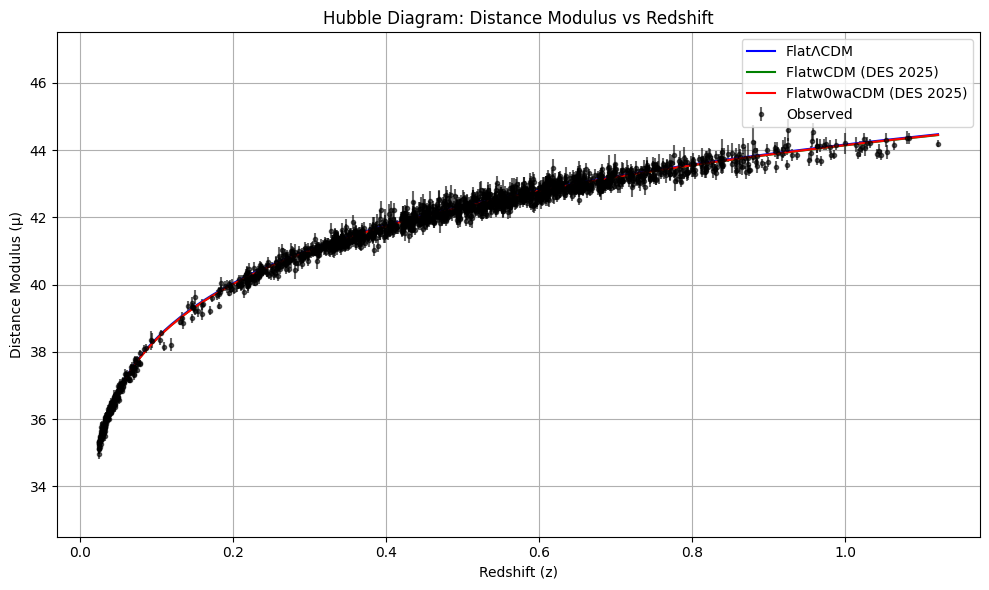

In [18]:
import astropy.units as u

zHD = df['zHD'].values
mu = df['MU'].values
mu_err = df['MUERR_FINAL'].values

sorted_indexes = np.argsort(zHD)
zHD_sorted = zHD[sorted_indexes]
mu_sorted = mu[sorted_indexes]
mu_err_sorted = mu_err[sorted_indexes]

model_LCDM = FlatLambdaCDM(H0 = 67.4, Om0 = 0.315)
model_wCDM = FlatwCDM(H0 = 68.1, Om0 = 0.317)
model_w0waCDM = Flatw0waCDM(H0 = 68.3, Om0 = 0.316, w0 = -1.01, wa = -0.11)

def get_mu(cosmology, zHD):
  d_lum = cosmology.luminosity_distance(zHD)
  return 5 * np.log10(d_lum.to(u.pc).value) - 5

mu_LCDM = get_mu(model_LCDM, zHD_sorted)
mu_wCDM = get_mu(model_wCDM, zHD_sorted)
mu_w0waCDM = get_mu(model_w0waCDM, zHD_sorted)

# ----------------------
# Graficar z vs mu con errores
# ----------------------
plt.figure(figsize=(10, 6))
plt.errorbar(zHD_sorted, mu_sorted, yerr=mu_err_sorted, fmt='o', markersize=3, label='Observed', color='black', alpha=0.6)

plt.plot(zHD_sorted, mu_LCDM, label='FlatΛCDM', color='blue')
plt.plot(zHD_sorted, mu_wCDM, label='FlatwCDM (DES 2025)', color='green')
plt.plot(zHD_sorted, mu_w0waCDM, label='Flatw0waCDM (DES 2025)', color='red')

plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus (μ)')
plt.legend()
plt.title('Hubble Diagram: Distance Modulus vs Redshift')
plt.grid(True)
plt.tight_layout()
plt.ylim(32.5, 47.5)
plt.show()


***

## Comparing our data to a cosmological model
 * To do this we will use an MCMC algorithm (`emcee`)
 * This requires a function to determine the goodness of fit between the data and model
 * We will 'minimise the posterior'; this is an extension of a traditional $\chi^2$ minimisation

 * The aim is to minimise the `logposterior`:
     * This is the sum of two terms : `loglikelihood` and `logprior`
     * i.e. $\ln \mathcal{P}(\theta | x,y) = \ln \mathcal{L}(\theta | x,y) + \ln \text{prior}(\theta)$
     * where $\theta$ are the model parameters being tested, $(x,y)$ is the data we have collected
 * The `logprior` encodes our knowledge of the _prior_ to collecting the data
     * It is therefore independent of the data
     * An assumption of a `uniform` (or flat) prior is often taken:
        * i.e. all values in parameter space (within a given bound) are equally likely to be true
     * We will assume that `(0.25 < $\Omega_m$ < 0.45)` & `(65. < $H_0$ < 75.)`
 * The `loglikelihood` measures the goodness of fit between the model and our dataset
     * $\ln \mathcal{L}(\theta | x,y) = -0.5 \times \left( N\times\ln(2\pi) + \sum_{i=0}^{N}2\times\ln(\sigma_i) + \sum_{i=0}^{N} \left(\frac{y - f(y,*\theta)}{\sigma_i}\right)^2\right)$
     * _Note_: the final term in this equation is the traditional $\chi^2$ formula


### Exercise:
 * Define the loglikelihood, logprior and logposterior between the DES5YR dataset and a FlatLCDM model
     * _Hint_ : If needed likelihood can be simplified to the $\chi^2$

***

FlatLambdaCDM

In [32]:
def log_prior(theta):
  H0, Om0 = theta
  if 65. < H0 < 75. and 0.25 < Om0 < 0.45:
    return 0.0
  return -np.inf

def log_likelihood(theta, zHD, mu_obs, mu_error):
  H0, Om0 = theta
  try:
    model = FlatLambdaCDM(H0 = H0, Om0 = Om0)
    mu_model = 5 * np.log10(model.luminosity_distance(zHD).to(u.pc).value) - 5
  except Exception:
    return -np.inf
  chi2 = np.sum(((mu_obs - mu_model) / mu_err) ** 2)
  return -0.5 * (len(zHD) * np.log(2*np.pi) + 2 * np.sum(np.log(mu_err)) + chi2)

def log_posterior(theta, zHD, mu_obs, mu_err):
  lp = log_prior(theta)
  if not np.isfinite(lp):
    return -np.inf
  return lp + log_likelihood(theta, zHD, mu_obs, mu_err)


wCDM

In [34]:
def log_prior(theta):
  H0, Om0 = theta
  if 65. < H0 < 75. and 0.25 < Om0 < 0.45:
    return 0.0
  return -np.inf

def log_likelihood(theta, zHD, mu_obs, mu_error):
  H0, Om0 = theta
  try:
    model = FlatwCDM(H0 = H0, Om0 = Om0)
    mu_model = 5 * np.log10(model.luminosity_distance(zHD).to(u.pc).value) - 5
  except Exception:
    return -np.inf
  chi2 = np.sum(((mu_obs - mu_model) / mu_err) ** 2)
  return -0.5 * (len(zHD) * np.log(2*np.pi) + 2 * np.sum(np.log(mu_err)) + chi2)

def log_posterior(theta, zHD, mu_obs, mu_err):
  lp = log_prior(theta)
  if not np.isfinite(lp):
    return -np.inf
  return lp + log_likelihood(theta, zHD, mu_obs, mu_err)

LambdaCDM

In [33]:
def log_prior(theta):
  H0, Om0 = theta
  if 65. < H0 < 75. and 0.25 < Om0 < 0.45:
    return 0.0
  return -np.inf

def log_likelihood(theta, zHD, mu_obs, mu_error):
  H0, Om0 = theta
  try:
    model = LambdaCDM(H0 = H0, Om0 = Om0)
    mu_model = 5 * np.log10(model.luminosity_distance(zHD).to(u.pc).value) - 5
  except Exception:
    return -np.inf
  chi2 = np.sum(((mu_obs - mu_model) / mu_err) ** 2)
  return -0.5 * (len(zHD) * np.log(2*np.pi) + 2 * np.sum(np.log(mu_err)) + chi2)

def log_posterior(theta, zHD, mu_obs, mu_err):
  lp = log_prior(theta)
  if not np.isfinite(lp):
    return -np.inf
  return lp + log_likelihood(theta, zHD, mu_obs, mu_err)

## Estimating the cosmological parameters
 * To do this we will use the `emcee` module: combining our measurements with the posterior code

## Exercise:
 * Use the `emcee` library to produce an MCMC chain for this problem.
    * _NB_: 50 walkers, each with 500 steps will be sufficient
 * Use the `corner` or `chainconsumer` library to visualise the results
 * Highlight the best-fit value
 * _Extension_ : Consider the `LambdaCDM` or `FlatwCDM` models

***

In [35]:

zHD = df['zHD'].values
mu = df['MU'].values
mu_err = df['MUERR_FINAL'].values

n_dim = 2
n_walkers = 50
n_steps = 500

np.random.seed(42)
initial = np.array([70.0, 0.3])  # valor inicial razonable
pos = initial + 1e-2 * np.random.randn(n_walkers, n_dim)

# Sampler
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior, args=(zHD, mu, mu_err))

# Correr MCMC
sampler.run_mcmc(pos, n_steps, progress=True)

100%|██████████| 500/500 [13:47<00:00,  1.66s/it]


State([[69.15653941  0.35265553]
 [69.10342389  0.36917205]
 [69.11760183  0.35598515]
 [69.18774335  0.35014027]
 [69.19366041  0.36095605]
 [69.20035258  0.34137643]
 [68.84779677  0.3685595 ]
 [69.43674002  0.34314087]
 [69.15358452  0.35435937]
 [69.1943955   0.36585484]
 [69.29223869  0.34521693]
 [69.28040127  0.35403552]
 [69.14190373  0.35472374]
 [69.0336165   0.35489724]
 [69.00899222  0.36736092]
 [69.23528992  0.35745929]
 [69.36869339  0.35404685]
 [69.3332488   0.34959618]
 [68.98051621  0.35704535]
 [69.25002134  0.34754532]
 [68.99475232  0.36419749]
 [69.21287428  0.34343461]
 [69.15661486  0.35682086]
 [69.17882174  0.36588797]
 [68.77010066  0.37541355]
 [69.27961355  0.34865066]
 [69.17063179  0.34970969]
 [68.83854666  0.36977872]
 [69.09848322  0.35878849]
 [69.24969571  0.34464847]
 [68.98612402  0.36360329]
 [69.24772261  0.34584137]
 [69.26098295  0.35535097]
 [68.79873997  0.36077217]
 [69.03065411  0.36760876]
 [68.97560291  0.36624389]
 [68.61468987  0.38186

**FlatLambdaCDM**

Shape of samples: (20000, 2)


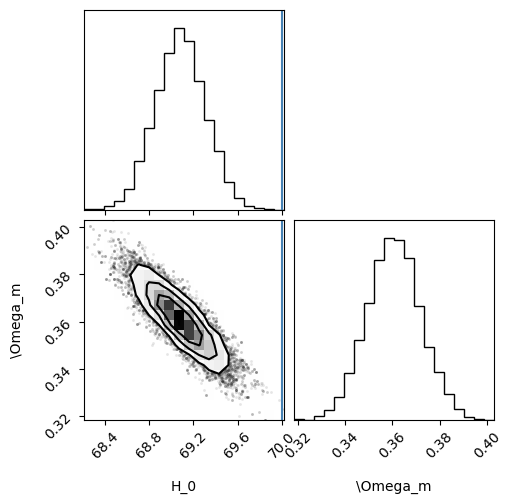

In [29]:
import corner

samples = sampler.get_chain(discard=100, flat=True)
print("Shape of samples:", samples.shape)

fig = corner.corner(samples, labels=["H_0", r"\Omega_m"], truths=[70, 0.3])

wCDM

Shape of samples: (400, 50, 2)


/usr/local/lib/python3.11/dist-packages/arviz/data/base.py:272: UserWarning: More chains (400) than draws (50). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


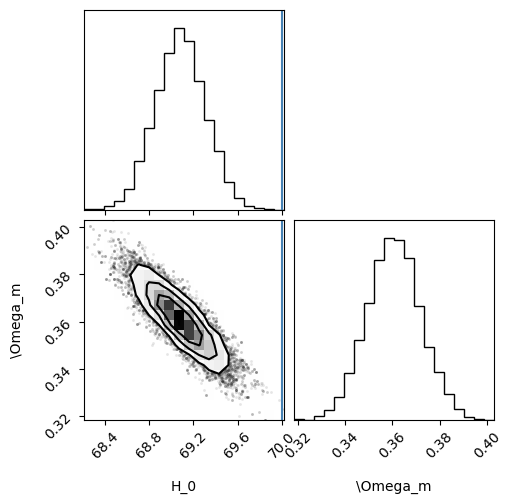

In [37]:
import corner

samples = sampler.get_chain(discard=100, flat=False)
print("Shape of samples:", samples.shape)

fig = corner.corner(samples, labels=["H_0", r"\Omega_m"], truths=[70, 0.3])

LambdaCDM

In [ ]:
import corner

samples = sampler.get_chain(discard=100, flat=True)
print("Shape of samples:", samples.shape)

fig = corner.corner(samples, labels=["H_0", r"\Omega_m"], truths=[70, 0.3])